# Lab 6 - Vision Transformers

In [1]:
import torch, torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision.transforms.v2 import (
    Compose,
    RandomHorizontalFlip,
    RandomResizedCrop,
    ToImage,
    ToDtype,
    Normalize,
)
from torch.utils.data import DataLoader
import math
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
import time

### Dataset preperation

In [2]:
transform = Compose(
    [
        RandomHorizontalFlip(p=0.5),
        RandomResizedCrop(size=(32, 32), scale=(0.8, 1), ratio=(0.9, 1.1)),
        ToImage(),
        ToDtype(torch.float32, scale=True),
        Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
    ]
)

train_cifar = torchvision.datasets.CIFAR10(
    "./lab6_data", train=True, download=True, transform=transform
)

test_transform =Compose(
    [
        ToImage(),
        ToDtype(torch.float32, scale=True),
        Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
    ]
)


test_cifar = torchvision.datasets.CIFAR10("./lab6_data", train=False, download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
train_cifar[0][0].shape

torch.Size([3, 32, 32])

### Model definition

No need for seperate function for cutting image into patches, we can do it with single `view()` call inside `forward()` method of our model.
On another note, I'm not using special CLS token for classification but rather calculate average of all other tokens.
I've also made a head a little bit bigger (added one extra Linear Layer)

In [38]:
#https://pytorch.org/tutorials/beginner/transformer_tutorial.html
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

class ClassifierCIFAR(nn.Module):
    def __init__(self):
        super(ClassifierCIFAR, self).__init__()

        self.no_of_classes = 10
        self.input_size = 32
        self.patch_size = 4
        self.sentence_length = (self.input_size // self.patch_size) ** 2
        self.embedding_size = 256
        self.no_of_transformers = 6
        self.dropout = 0.2

        self.patch_embedding = nn.Conv2d(
            3,
            self.embedding_size,
            kernel_size=self.patch_size,
            stride=self.patch_size,
            padding=0,
        )

        self.positional_encoding = PositionalEncoding(self.embedding_size, self.dropout)

        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=self.embedding_size,
                nhead=8,
                dim_feedforward=512,
                dropout=self.dropout,
                activation="gelu",
                norm_first=True,
                batch_first=True
            ),
            self.no_of_transformers,
        )

        self.feedforward = nn.Sequential(
            nn.LayerNorm(self.embedding_size),
            nn.Linear(self.embedding_size, self.embedding_size),
            nn.GELU(),
            nn.Linear(self.embedding_size, self.no_of_classes),
        )

    def forward(self, x):
        b, c, h, w = x.shape

        # embedding patches using convolution, flattening them and putting dimensions in right order
        tokens = self.patch_embedding(
            x
        ).view(b, self.embedding_size, self.sentence_length).permute(0, 2, 1) 

        # adding positional encoding
        tokens = tokens + self.positional_encoding(tokens)

        features = self.transformer(tokens)

        # extracting CLS tokens and passing to feedforward
        out = self.feedforward(features.mean(dim=1))

        return out

### Training

In [44]:
BATCH_SIZE = 400 # largest I could fit into my GPU
EPOCHS = 160
START_EPOCH = 6
model = ClassifierCIFAR().to("cuda")
model.train()

optimizer = AdamW(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=75, gamma=0.1)
criterion = nn.CrossEntropyLoss()

# loading from previous runs
data = torch.load('lab6_data/model_7')
model.load_state_dict(data)
data = torch.load('lab6_data/optimizer_7')
scheduler.load_state_dict(data['scheduler'])
optimizer.load_state_dict(data['optimizer'])

train_dataloader = DataLoader(train_cifar, batch_size=BATCH_SIZE, shuffle=True)
start_time = time.time()
for epoch in  range(START_EPOCH, EPOCHS):
    cum_loss = 0
    for data, label in train_dataloader:
        optimizer.zero_grad()
        data, label = data.to("cuda"), label.to("cuda")

        output = model(data)
        
        loss = criterion(output,label)
        loss.backward()
        optimizer.step()

        cum_loss += loss.detach().cpu().item() * data.shape[0]

    scheduler.step()
    print(f'Epoch: {epoch}, Loss: {cum_loss / len(train_dataloader)}, time: {(time.time() - start_time) / 60:.2f}min')


Epoch: 6, Loss: 786.0145736694336, time: 3.23min
Epoch: 7, Loss: 789.532921218872, time: 7.48min
Epoch: 8, Loss: 781.4656314849854, time: 11.68min
Epoch: 9, Loss: 772.4646377563477, time: 15.90min
Epoch: 10, Loss: 769.9245090484619, time: 20.09min
Epoch: 11, Loss: 764.606177520752, time: 24.23min
Epoch: 12, Loss: 762.1738498687744, time: 28.20min
Epoch: 13, Loss: 754.0347030639648, time: 32.24min
Epoch: 14, Loss: 749.935619354248, time: 35.89min
Epoch: 15, Loss: 750.7913146972656, time: 38.96min
Epoch: 16, Loss: 747.3842060089112, time: 41.60min
Epoch: 17, Loss: 752.7074794769287, time: 44.26min
Epoch: 18, Loss: 744.342322921753, time: 46.96min
Epoch: 19, Loss: 762.3053482055664, time: 49.80min
Epoch: 20, Loss: 789.1593585968018, time: 52.62min
Epoch: 21, Loss: 757.5073719024658, time: 55.38min
Epoch: 22, Loss: 757.5611419677734, time: 58.16min
Epoch: 23, Loss: 748.5347995758057, time: 61.00min
Epoch: 24, Loss: 744.0100494384766, time: 63.75min
Epoch: 25, Loss: 764.5131568908691, time:

In [42]:
torch.save(model.state_dict(), f"lab6_data/model_{epoch}")
torch.save(
    {
        "epoch": epoch,
        "loss": loss,
        "optimizer": optimizer.state_dict(),
        "scheduler": scheduler.state_dict(),
    },
    f"lab6_data/optimizer_{epoch}",
)

In [45]:
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship','truck']

tensor([0, 4, 9, 8, 2, 7, 7, 9, 8, 9, 6, 0, 2, 0, 8, 1, 1, 1, 6, 7, 6, 1, 6, 5,
        4, 0, 1, 7, 0, 5, 6, 6, 8, 7, 5, 2, 9, 7, 4, 5, 2, 7, 5, 2, 3, 9, 1, 6,
        9, 5, 7, 8, 0, 6, 1, 0, 9, 8, 8, 9, 9, 5, 5, 7, 4, 1, 6, 5, 1, 9, 7, 5,
        1, 0, 8, 1, 0, 8, 5, 6, 6, 6, 1, 3, 7, 8, 9, 0, 6, 9, 3, 5, 9, 9, 0, 0,
        6, 7, 9, 3, 9, 7, 7, 6, 8, 4, 5, 1, 9, 7, 6, 6, 6, 4, 1, 9, 1, 0, 2, 9,
        5, 8, 3, 5, 4, 1, 7, 9, 1, 3, 1, 0, 7, 7, 8, 4, 6, 9, 6, 9, 0, 5, 4, 0,
        5, 5, 9, 9, 0, 8, 4, 0, 0, 7, 0, 4, 4, 1, 4, 2, 0, 4, 7, 7, 0, 8, 9, 7,
        5, 0, 3, 7, 0, 6, 8, 1, 6, 8, 7, 8, 9, 5, 6, 7, 0, 1, 4, 1, 6, 5, 8, 1,
        1, 3, 5, 9, 6, 9, 6, 0, 6, 9, 7, 0, 3, 2, 8, 9, 6, 6, 0, 4, 4, 5, 8, 9,
        6, 6, 4, 7, 7, 5, 6, 4, 1, 1, 9, 9, 0, 7, 9, 7, 0, 9, 0, 4, 6, 3, 9, 1,
        9, 6, 2, 2, 2, 8, 3, 3, 6, 3, 1, 7, 2, 2, 4, 2, 5, 1, 6, 0, 6, 4, 1, 6,
        2, 6, 6, 5, 3, 9, 7, 4, 6, 1, 0, 6, 0, 4, 7, 6, 4, 5, 0, 9, 1, 9, 9, 1,
        9, 7, 6, 7, 2, 4, 7, 9, 7, 0, 1,

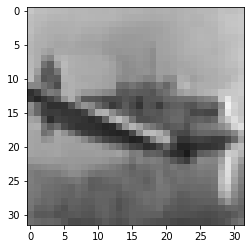

In [52]:
from collections import Counter

model.eval()
test_dataloader = DataLoader(test_cifar, batch_size=BATCH_SIZE, shuffle=True)
for img, label in test_dataloader:
    plt.imshow(img[0].permute(1,2,0).cpu().numpy())
    with torch.inference_mode():
        print(torch.argmax(model(img.to("cuda")), 1))
        print(label)
        print(Counter(list(torch.argmax(model(img.to("cuda")), 1).detach().cpu().numpy())))
        print(f'Model prediction: {cifar10_classes[torch.argmax(model(img.to("cuda")), 1)[0]]}')
        print(f'Ground truth: {cifar10_classes[label[0]]}') 
        break

### Metrics on test dataset

In [55]:
test_dataloader = DataLoader(test_cifar, batch_size=400, shuffle=True)
model.eval()
with torch.no_grad():
    TP = 0

    for data, labels in test_dataloader:
        data, labels = data.to("cuda"), labels.to("cuda")
        output = model(data)
        for o, l in zip(torch.argmax(output, 1), labels):
            if o == l:
                TP += 1

    print(f"Accuracy: {TP / len(test_dataloader) / BATCH_SIZE}")

Accuracy: 0.374


We have 10 classes, so we can see the classifier was trained. Investigating loss during training we can see that model was still capable of learning more, because the loss was decreasing. Maybe we should use more epochs, or choose better learning rate schedule to train the model faster.